In [20]:
import torch
import torch.nn as nn
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import json
import mcubes
import trimesh

In [21]:
# worker functions
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join('assets', cp_name))

def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
print(get_device())

cuda


# Camera / Dataset

In [22]:
'''
Dataset should be a folder that contains the transforms.json file from the colmap2nerf script in the InstantNGP repo
and a folder called imgs containing your dataset of images. Training images should contain the string "train" and testing
images should contain the string "test"
'''
def get_rays(datapath, mode='train'):
    # renamed images in the train dataset as train_xxxx and test_xxxx for test - changing the mode changes which subset to generate rays from

    # Transformation matrix file is from InstantNGP's colmap2nerf.py script
    file = open(datapath + '/transforms.json')
    data = json.load(file)
    data_extract = [(f["file_path"], f["transform_matrix"]) for f in data["frames"] if f'{mode}' in f["file_path"]]

    # focal length is the same for this entire dataset
    focal_length = (data["fl_x"] + data["fl_y"]) / 2 # taking average of focal lengths as they are very close

    N = len(data_extract) # size of image dataset

    images = []
    poses = np.zeros([N, 4, 4])

    for i in range(len(data_extract)):
        img = imageio.imread(datapath + '/imgs/' + data_extract[i][0]) / 255. # want pixel value to go from 0 to 1
        images.append(img[None, ...])

        matrix = np.array(data_extract[i][1])
        poses[i] = matrix

    images = np.concatenate(images)
    H = images.shape[1] # height
    W = images.shape[2] # width

    assert len(images) == len(poses)
    print(images.shape)

    if images.shape[3] == 4: # if it has an alpha channel (opacity), convert to just regular RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3)) # ray origins
    rays_d = np.zeros((N, H*W, 3)) # ray directions
    target_px_values = images.reshape((N, H*W, 3)) # ground truth for a pixel

    for i in range(N):

        c2w = poses[i] # camera to world transformation matrix
        
        # create a mesh grid where 0,0 is the centre of the image
        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), -np.ones_like(u) * focal_length), axis=-1) # v is negative because you want convential upward facing y - same with focal length and inward z (x, -y ,-z)
        
        # apply rotation matrix - only use submatrix that affects rotation (3x3)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1) # remove virtual dimension at -1

        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) # normalize the 400x400 grid along the last dimension
        
        rays_d[i] = dirs.reshape(-1, 3) # reshape to match rays_o (H*W, 3)
        rays_o[i] += c2w[:3, 3] # apply translation vector to origin

    return rays_o, rays_d, target_px_values

In [24]:
batch_size = 1024

# Size : 26, 445, 445, 3

o, d, target_px_values = get_rays('assets/latte', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float), 
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float), 
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                                   batch_size=batch_size,
                                   shuffle=True)

# warmup dataloader is for the first epoch of the NN training - it is focused on the centre of the image so that the NN converges on those values early on
dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(33, 445, 445, 3)[: 100:300, 100:300, :].reshape(-1, 3).type(torch.float), 
                                          torch.from_numpy(d).reshape(33, 445, 445, 3)[: 100:300, 100:300, :].reshape(-1, 3).type(torch.float), 
                                          torch.from_numpy(target_px_values).reshape(33, 445, 445, 3)[: 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                                          batch_size=batch_size,
                                          shuffle=True)


test_o, test_d, test_target_px_values = get_rays('assets/latte', mode='test')

C:\Users\Kirill\AppData\Local\Temp\ipykernel_30764\3576297900.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + data_extract[i][0]) / 255. # want pixel value to go from 0 to 1


(33, 445, 445, 3)
(2, 445, 445, 3)


# Rendering

In [25]:
def compute_accumulated_transmittance(betas):
    '''
    This is the T(i) function that calculates accumulated transmittance. This can be defined as
    the probablity of the ray travelling from tn to tf without hitting another particle. Normally a cumulative
    sum is done along the product of the density and delta for each value up to i-1. This looks like:

    accumulated = torch.exp(-1 * torch.cumsum(density * delta.unsqueeze(0), 1))

    we can reuse the alphas we already calculated though because (density * delta.unsqueeze(0), 1) = 1 - alpha
    and since exp^a * exp^b = exp^a+b we can also just do the cumulative product to get the same result.

    the final line replaces the last delta calculation as we set the final delta value to inf - we just shift all values to the right
    and have the first value for each ray be = 1
    '''
    accumulated_transmittance = torch.cumprod(betas, 1) # cumulative product of 1 - alpha
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                     accumulated_transmittance[:, :-1]), dim=1)

def rendering(model, rays_o, rays_d, tn, tf, n_samples=100, device='cpu'): 
    # compute integral from tn to tf on each of the rays - n_samples is the number of approximations in the integral

    t = torch.linspace(tn, tf, n_samples).to(device)
    # compute delta
    # = t_i - t_i-1 (size is n_samples - 1 with this logic so need to add 1 more to the dim) t[1:] is all ti, t[:-1] is ti-1 at all index
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device))) # last delta value is set to inf (1e10 is good enough)

    # t is size (n_samples)
    # rays_o is size (# of rays, 3)
    # we want r(t) to be size (# of rays, n_samples, 3) becuase for each ray we want to know the what the point(color) is at the sample and 3 is RGB
    # need to reshape tensors with virtual dims t -> (1, n_samples, 1) rays_o -> (# of rays, 1, 3) to get the result we want

    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # r(t) = o + td, tells you where the ray is at position d and time t - shape is (n_rays, n_samples, 1)

    colors, density = model.forward(x.reshape(-1, 3), rays_d.expand(x.shape[1], x.shape[0], 3).transpose(0, 1).reshape(-1, 3)) # need to reshape because model expects shape of [batch_size, 3]

    # reshape back into size we want
    colors = colors.reshape((x.shape[0], n_samples, 3)) # (n_rays, n_samples, 3)
    density = density.reshape((x.shape[0], n_samples))

    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # this is the alpha equation from the paper - shape is same as x/r(t): (n_rays, n_samples, 1)
    T = compute_accumulated_transmittance(1 - alpha) * alpha

    c = (T.unsqueeze(-1) * colors).sum(1) # this is C(r) - want to sum along samples which is dimension 1 T&alpha missing last dimension for proper summation

    return c

# Model

In [26]:
class Nerf(nn.Module):
    def __init__(self, l_pos=10, l_dir=4, hidden_dims=256):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Linear(l_pos * 6 + 3, hidden_dims), # l_pos x2 for cos & sin and also x3 for x,y,z - so x6; +3 for because we also concatenate x,y,z to pos encoding (not mentioned in paper but is in the code implementation)
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Linear(hidden_dims + l_pos * 6 + 3, hidden_dims), # add pos_encoding skip connection
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims + 1), # no activation on last layer - density(sigma) is the last dimension of the output on this layer
        )

        self.block3 = nn.Sequential(
            nn.Linear(hidden_dims + l_dir * 6 + 3, hidden_dims // 2), # we do not want density affected by direction so we only now add pos_encoding of direction ( for color )
            nn.ReLU(),
            nn.Linear(hidden_dims // 2, 3), # output is 3 dim color (RGB)
            nn.Sigmoid(),
        )

        self.l_pos = l_pos
        self.l_dir = l_dir
    
    def positonal_encoding(self, x, L):
        out = [x] # we are concatenating x to the result of the Fourier features (the +3 dimension in the NN inputs)
        for j in range(L):
            out.append(torch.sin(2**j * x)) # for each component get the cos/sin of 2^(l=1, ..., l=10)
            out.append(torch.cos(2**j * x))
        return torch.cat(out, dim=1)

    
    def forward(self, xyz, d):
        
        x_emb = self.positonal_encoding(xyz, self.l_pos) # (batch_size, l_pos *6 + 3) (63)
        dir_emb = self.positonal_encoding(d, self.l_dir) # (batch_size, l_dir *6 + 3) (27)

        h = self.block1(x_emb) # (batch_size, hidden_dims)
        h = self.block2(torch.cat((h, x_emb), dim=1)) # (batch_size, hidden_dims + 1)
        sigma = h[:, -1] # extract sigma
        h = h[:, :-1]
        c = self.block3(torch.cat((h, dir_emb), dim=1))

        return c, torch.relu(sigma) # normalize sigma so no non-negative density value

# Training

In [27]:
def training(model, optimizer, scheduler, tn, tf, n_samples, nb_epochs, data_loader, device=get_device()):

    training_loss = []

    for _ in range(nb_epochs):
        for batch in tqdm(data_loader):
            o = batch[:, :3].to(device) # origin is first 3 values
            d = batch[:, 3:6].to(device) # direction is 2nd set of 3 values
            target = batch[:, 6:].to(device) # target is final 3 values

            prediction = rendering(model, o, d, tn, tf, n_samples, device)

            loss = ((prediction - target)**2).mean()

            
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
        scheduler.step() # reduces learning rate for each epoch
    
    return training_loss

In [28]:
device = get_device()

# hyperparameters
tn = 1
tf = 8
nb_epochs = 15
lr = 1e-3
gamma = 0.5
n_samples = 100
l_pos = 10
l_dir = 4

model = Nerf().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

# Dataloader Warmup Epochs
training_loss = training(model, optimizer, scheduler, tn, tf, n_samples, 3, dataloader_warmup, device=device)
# Plot Dataloader Warmup Loss
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, n_samples, nb_epochs, dataloader, device=device)

In [28]:
# save_model_checkpoint(model, "Nerf-Latte-Images-Corrected-Focal-15-Epochs")

In [29]:
_ = load_model_from_checkpoint(model, "assets/Nerf-Latte-Images-Corrected-Focal-15-Epochs")

In [30]:
# function for converting MSE to PSNR
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))

# function for testing model on images it has not seen before
@torch.no_grad()
def test(model, o, d, tn, tf, n_samples=100, chunk_size=10, H=445, W=445, target=None):

    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)

    

    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, n_samples=n_samples, device=o_batch.device)
        image.append(img_batch)
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()

    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)

    if target is not None:
         return image, mse, psnr
    else:
        return image

In [33]:
tn = 1
tf = 8
i = 10
H, W = 445,445
img, mse, psnr = test(model, torch.from_numpy(o[i]).to(device).float(), torch.from_numpy(d[i]).to(device).float(), tn, tf, n_samples=100, chunk_size=20, H=H, W=W, target=
           target_px_values[i].reshape(H,W,3))
psnr

chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk
chunk


29.80170079878637

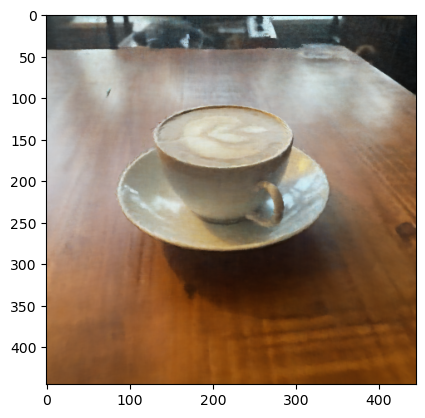

In [34]:
# show predicted image
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


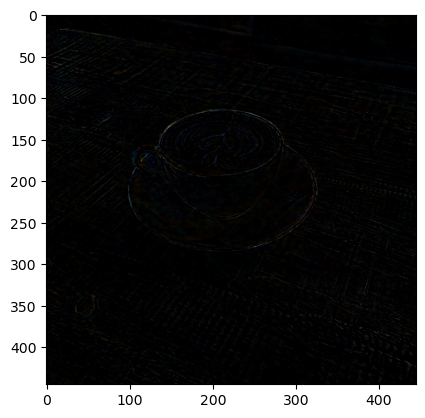

In [45]:
# show predicted image loss
plt.imshow(img - target_px_values[i].reshape(H,W,3))

In [35]:
# create meshgrid representing 3D space
N = 100
scale = 1.5

x = torch.linspace(-scale, scale, N)
y = torch.linspace(-scale, scale, N)
z = torch.linspace(-scale, scale, N)

x, y, z = torch.meshgrid((x, y, z))

xyz = torch.cat((
    x.reshape(-1, 1),
    y.reshape(-1, 1),
    z.reshape(-1, 1),
                 ), dim=1)

c:\Users\Kirill\.conda\envs\cv-env\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [36]:
# fill meshgrid with density predictions
with torch.no_grad():
    _, density = model.forward(xyz.to(device), torch.zeros_like(xyz).to(device))

density = density.cpu().numpy().reshape(N, N, N)

In [47]:
# render meshgrid using marching cubes
vertices, triangles = mcubes.marching_cubes(density, np.mean(density))
mesh = trimesh.Trimesh(vertices / N, triangles)
mesh.show()

In [ ]:
"""
    To get color we can take the normal of the mesh points. At the normal we take a camera and face it opposite of the normal (back at the mesh)
    and then we ask our NN what color is at that point - we do this for all points to get the color of the mesh. (This can have errors of making objects that are hidden to have
    the color of the image they are hidden behind.)

    Can fix this with using multiple views instead of just the single -normal view
"""